In [ ]:
# Import necessary libraries
import os
import random
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
from PIL import Image


import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import random_split


In [ ]:
device = 'cuda'

In [ ]:
!pip install sam2

In [ ]:
!git clone https://github.com/SuperMedIntel/Medical-SAM2

Cloning into 'Medical-SAM2'...
remote: Enumerating objects: 241, done.
remote: Counting objects: 100% (96/96), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 241 (delta 69), reused 51 (delta 51), pack-reused 145 (from 1)
Receiving objects: 100% (241/241), 23.51 MiB | 21.42 MiB/s, done.
Resolving deltas: 100% (95/95), done.


In [ ]:
!git clone https://github.com/facebookresearch/sam2

Cloning into 'sam2'...
remote: Enumerating objects: 1070, done.
remote: Total 1070 (delta 0), reused 0 (delta 0), pack-reused 1070 (from 1)
Receiving objects: 100% (1070/1070), 128.11 MiB | 24.42 MiB/s, done.
Resolving deltas: 100% (381/381), done.


In [ ]:
!mv sam2 SAM2

In [ ]:
!sh Medical-SAM2/checkpoints/download_ckpts.sh

--2025-05-05 01:18:14--  https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_tiny.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.226.210.111, 13.226.210.25, 13.226.210.78, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.226.210.111|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 155906050 (149M) [application/vnd.snesdev-page-table]
Saving to: ‘sam2_hiera_tiny.pt’

sam2_hiera_tiny.pt  100%[===================>] 148.68M  84.1MB/s    in 1.8s    

2025-05-05 01:18:16 (84.1 MB/s) - ‘sam2_hiera_tiny.pt’ saved [155906050/155906050]

--2025-05-05 01:18:16--  https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.226.210.111, 13.226.210.25, 13.226.210.78, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.226.210.111|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 184309650 (176M) [app

In [ ]:
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

sam2_checkpoint = "sam2_hiera_tiny.pt"

sam2_model = build_sam2("sam2_hiera_t", sam2_checkpoint, device=device)

predictor = SAM2ImagePredictor(sam2_model)

In [ ]:
# Set the data path
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
data_path = "/content/drive/MyDrive/MPI_mice"
os.listdir(data_path)

['1953_mouse_MPI (1)',
 '1952_mouse_MPI (1)',
 '1953_mouse_MPI',
 '1952_mouse_MPI']

In [ ]:
class OdorGlomeruliDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []

        # Dynamically get mouse folders
        mouse_folders = sorted(os.listdir(root_dir))
        mouse_folders = [folder for folder in mouse_folders if " (1)" not in folder]

        # Dynamically get odorant folders from the first mouse folder
        first_mouse_dir = os.path.join(root_dir, mouse_folders[0])
        odorant_folders = sorted(os.listdir(first_mouse_dir))
        odorant_folders = [folder for folder in odorant_folders if "2_ethyl_butyric_acid" not in folder]
        odorant_labels = {odor: idx for idx, odor in enumerate(odorant_folders)}

        for mouse in mouse_folders:
            mouse_path = os.path.join(root_dir, mouse)
            for odorant in odorant_folders:
                odor_path = os.path.join(mouse_path, odorant)
                images = sorted(os.listdir(odor_path))
                for img_name in images:
                    img_path = os.path.join(odor_path, img_name)
                    label = odorant_labels[odorant]
                    self.data.append((img_path, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, odor_label = self.data[idx]
        image = Image.open(img_path).convert('L')

        if self.transform:
            image = self.transform(image)

        return odor_label, image


In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2, random
import numpy as np

class RandomPatchGaussianBlur(A.ImageOnlyTransform):
    """Blur a random rectangular patch with a Gaussian kernel."""
    def __init__(self, max_frac=0.25, blur_limit=(3, 7),
                 always_apply=False, p=0.5):
        super().__init__(always_apply, p)
        self.max_frac, self.blur_limit = max_frac, blur_limit

    def apply(self, img, k=3, **params):
        h, w = img.shape[:2]
        ph, pw = int(h * self.max_frac), int(w * self.max_frac)
        y1 = random.randint(0, h - ph)
        x1 = random.randint(0, w - pw)
        img[y1:y1+ph, x1:x1+pw] = cv2.GaussianBlur(img[y1:y1+ph, x1:x1+pw],
                                                   (k, k), 0)
        return img

    def get_params(self):
        k = random.randrange(self.blur_limit[0] | 1,
                             self.blur_limit[1] + 1, 2)  # odd kernel
        return {"k": k}

# ─────────────────────────────────────────────────────────────
def build_aug_pipeline(train=True, img_size=128):
    """
    Augmentations suited to single‑channel medical data
    – slight crops/zooms, small rotations, elastic warps,
      local patch blur **and** whole‑image Gaussian blur.
    """
    if train:
        return A.Compose([
            # Geometry
            A.RandomResizedCrop(img_size, img_size,
                                scale=(0.90, 1.00),
                                ratio=(0.95, 1.05), p=1.0),
            A.Rotate(limit=5,
                     border_mode=cv2.BORDER_REFLECT_101, p=0.9),

            # Elastic deformation
            A.ElasticTransform(alpha=60, sigma=8,
                               border_mode=cv2.BORDER_REFLECT_101, p=0.4),

            # Whole‑image Gaussian blur  ← new line
            A.GaussianBlur(blur_limit=(3, 7), p=0.3),

            # Patch‑wise Gaussian blur
            RandomPatchGaussianBlur(max_frac=0.20, blur_limit=(3, 7), p=0.5),

            # Sensor noise
            A.GaussNoise(p=0.3),

        ])
    else:
        return A.Compose([
            A.Resize(img_size, img_size),
        ])

train_tf = build_aug_pipeline(train=True, img_size=(256,256))

In [ ]:
transform = A.Compose([
    A.Resize(height=256, width=256),
    train_tf,
])
tensor_transform = A.Compose([
    transform,
    A.ToTensorV2(),
])


1952_mouse_MPI | Odorant '2_3_pentanedione': Mean=80.2190, Std=58.0470, Min=0.0000, Max=255.0000
1952_mouse_MPI | Odorant '2_4_dimethyl_acetophenone': Mean=70.1767, Std=57.6426, Min=0.0000, Max=255.0000
1952_mouse_MPI | Odorant '2_methyl_butyraldehyde': Mean=80.2908, Std=61.4076, Min=0.0000, Max=255.0000
1952_mouse_MPI | Odorant '33_dimethyl_butyric_acid': Mean=73.0395, Std=65.5058, Min=0.0000, Max=255.0000
1952_mouse_MPI | Odorant '3_methylvaleric_acid': Mean=63.4443, Std=53.6073, Min=0.0000, Max=255.0000
1952_mouse_MPI | Odorant '4_heptanone': Mean=63.9805, Std=52.1885, Min=0.0000, Max=255.0000
1952_mouse_MPI | Odorant 'acetic_acid': Mean=89.3383, Std=50.7474, Min=0.0000, Max=255.0000
1952_mouse_MPI | Odorant 'gerinol': Mean=84.9605, Std=50.2487, Min=0.0000, Max=255.0000
1952_mouse_MPI | Odorant 'm_anisaldehyde': Mean=81.1275, Std=59.2322, Min=0.0000, Max=255.0000
1952_mouse_MPI | Odorant 'n_methyl_piperdine': Mean=77.7433, Std=60.5166, Min=0.0000, Max=255.0000
1953_mouse_MPI | Odora

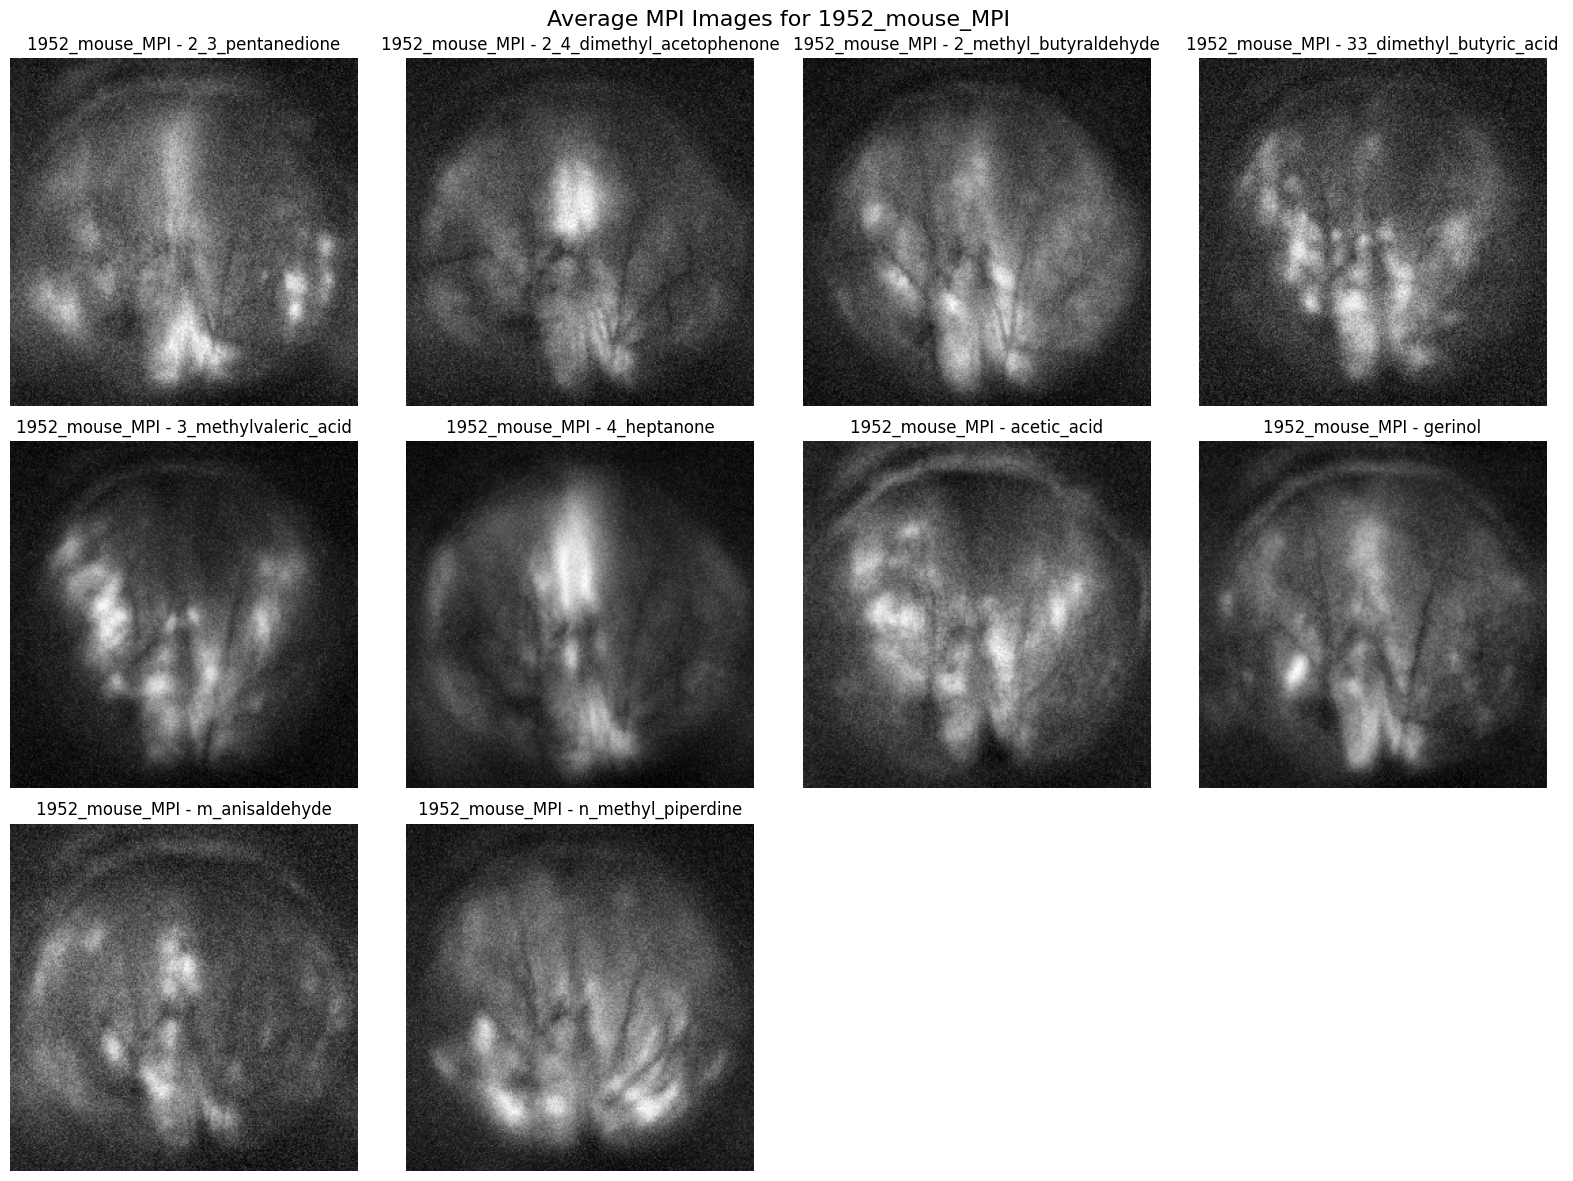

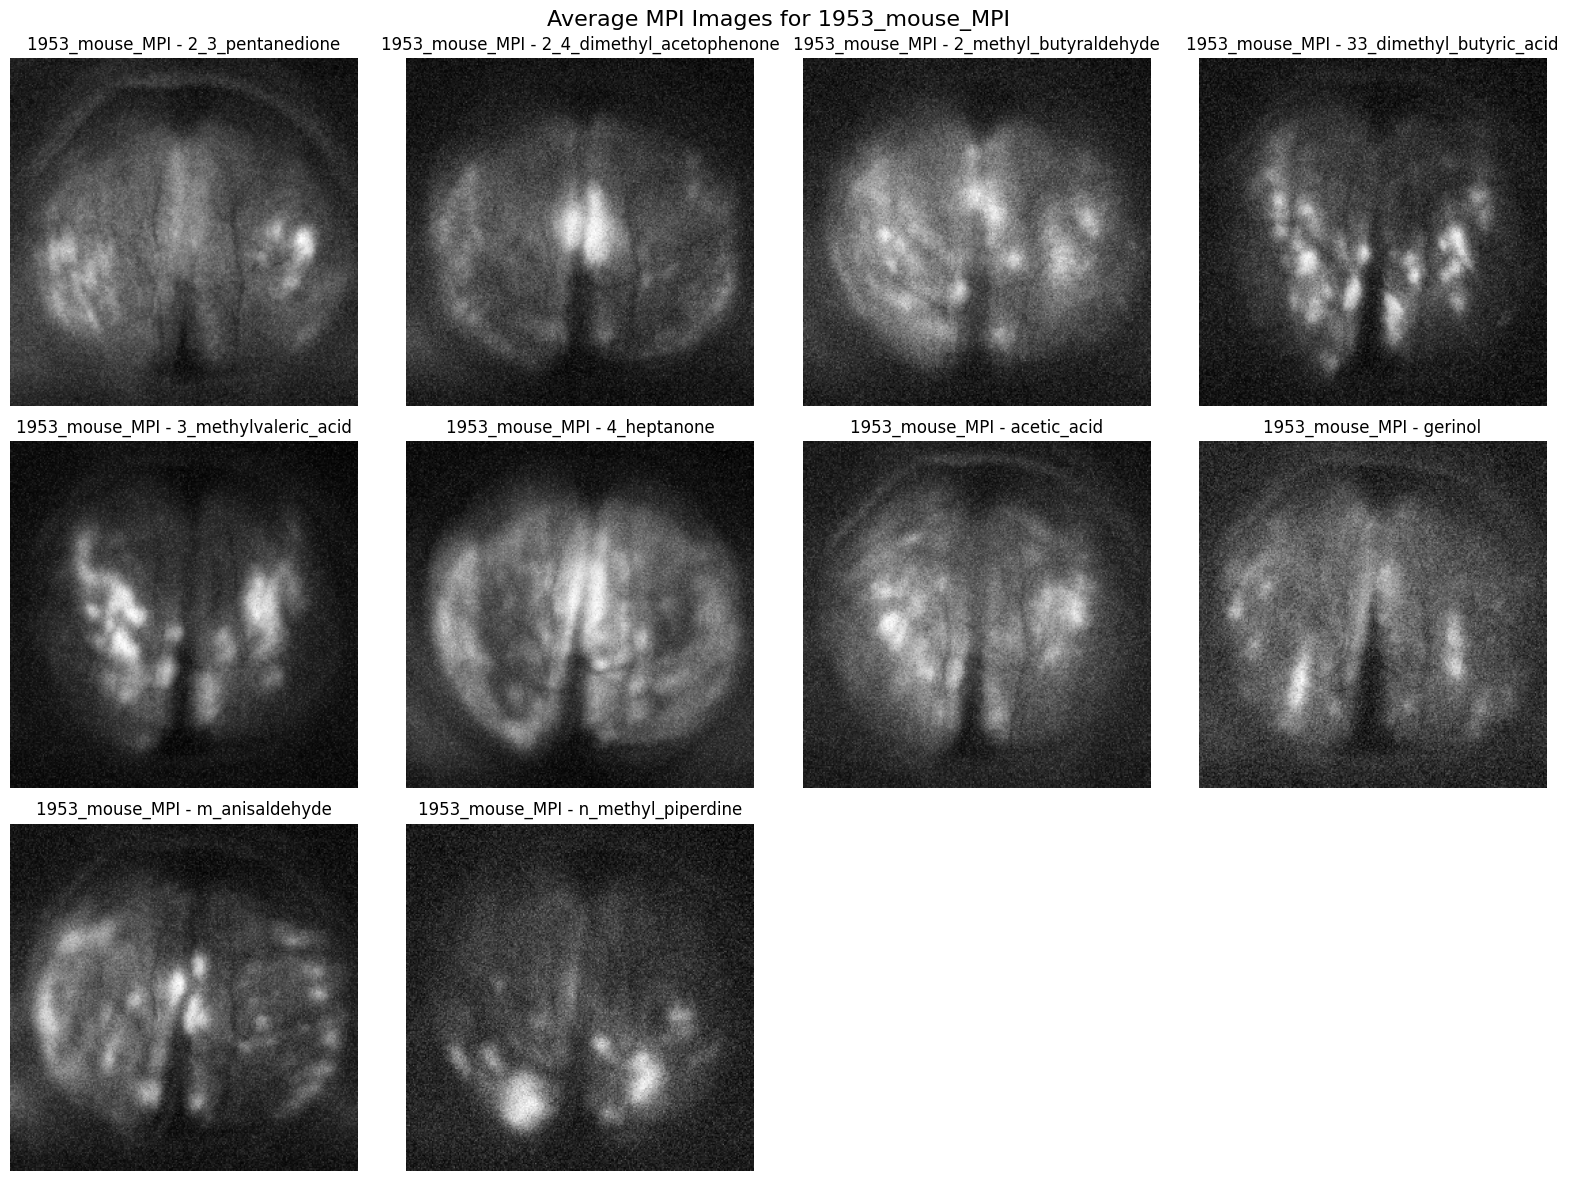

In [ ]:

# Prepare mouse folders dynamically
mouse_folders = sorted(os.listdir(data_path))
mouse_folders = [folder for folder in mouse_folders if " (1)" not in folder]
odorant_stats = {}

for mouse in mouse_folders:
    mouse_path = os.path.join(data_path, mouse)
    odorant_folders = sorted(os.listdir(mouse_path))
    odorant_folders = [folder for folder in odorant_folders if "2_ethyl_butyric_acid" not in folder]

    odorant_images = {odor: [] for odor in odorant_folders}

    # Load images
    for odorant in odorant_folders:
        odor_path = os.path.join(mouse_path, odorant)
        images = sorted(os.listdir(odor_path))

        for img_name in images:
            img_path = os.path.join(odor_path, img_name)
            image = np.array(Image.open(img_path).convert('L'))
            image = transform(image=image)['image']
            odorant_images[odorant].append(image)

    # Compute stats per odorant clearly
    odorant_stats[mouse] = {}
    for odorant, images in odorant_images.items():
        images_array = np.stack(images)

        mean_val = images_array.mean()
        std_val = images_array.std()
        min_val = images_array.min()
        max_val = images_array.max()

        avg_image = images_array.mean(axis=0)

        odorant_stats[mouse][odorant] = {
            "mean": mean_val,
            "std": std_val,
            "min": min_val,
            "max": max_val,
            "avg_image": avg_image
        }

        print(f"{mouse} | Odorant '{odorant}': Mean={mean_val:.4f}, Std={std_val:.4f}, Min={min_val:.4f}, Max={max_val:.4f}")

# Clearly visualize average MPI images mouse-wise
for mouse in mouse_folders:
    odorants = sorted(odorant_stats[mouse].keys())
    num_odorants = len(odorants)

    cols = 4
    rows = (num_odorants + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(16, 4 * rows))
    axes = axes.flatten()

    for idx, odorant in enumerate(odorants):
        ax = axes[idx]
        avg_img = odorant_stats[mouse][odorant]["avg_image"]
        ax.imshow(avg_img, cmap='gray')
        ax.set_title(f"{mouse} - {odorant}")
        ax.axis('off')

    # Hide unused subplots
    for idx in range(num_odorants, len(axes)):
        axes[idx].axis('off')

    plt.suptitle(f"Average MPI Images for {mouse}", fontsize=16)
    plt.tight_layout()
    plt.show()


#### lets start with - within mouse MINE appraoch

In [ ]:
def embed_image(image):
  image = np.array(image.convert("RGB"))
  predictor.set_image(image)
  emb = predictor.get_image_embedding()
  emb = torch.nn.functional.max_pool2d(emb, kernel_size=4, stride=4)
  emb = emb.flatten()
  return emb

In [ ]:
class AlbWrapper:
    """Make an Albumentations pipeline look like a torchvision transform."""
    def __init__(self, aug):
        self.aug = aug

    def __call__(self, pil_img):
        arr = np.expand_dims(np.array(pil_img), -1)      # PIL → (H,W,1)
        return self.aug(image=arr)["image"]              # torch tensor

In [ ]:
train_tf = AlbWrapper(build_aug_pipeline(train=True, img_size=(256,256)))

class MINEWithinMouseDataset(Dataset):
    def __init__(self, root_dir, mouse_name, transform=train_tf, aug_repeats=5):
        self.transform = transform
        self.aug_repeats = aug_repeats
        mouse_path = os.path.join(root_dir, mouse_name)
        self.data = []
        self.idx_to_item = {}

        odorant_folders = sorted(os.listdir(mouse_path))
        odorant_folders = [folder for folder in odorant_folders if "2_ethyl_butyric_acid" not in folder]
        self.odorant_labels = {odor: idx for idx, odor in enumerate(odorant_folders)}
        self.label_to_images = {idx: [] for idx in range(len(odorant_folders))}

        for odorant in odorant_folders:
            odor_path = os.path.join(mouse_path, odorant)
            images = sorted(os.listdir(odor_path))
            label = self.odorant_labels[odorant]

            for img_name in images:
                img_path = os.path.join(odor_path, img_name)
                self.label_to_images[label].append(img_path)
                self.data.append((img_path, label))

        self.labels = list(self.label_to_images.keys())

    def __len__(self):
        return len(self.data * self.aug_repeats)

    def __getitem__(self, idx):
        if idx in self.idx_to_item:
          return self.idx_to_item[idx]
        # Joint pair
        img_path, odor_label = self.data[int(np.floor(idx/self.aug_repeats))]
        joint_image = np.array(Image.open(img_path).convert('L'))

        if self.transform:
            joint_image = self.transform(image=joint_image)

        # Marginal pair: image from random incorrect label
        random_label = odor_label
        while random_label == odor_label:
            random_label = random.choice(self.labels)

        marginal_img_path = random.choice(self.label_to_images[random_label])
        marginal_image = np.array(Image.open(marginal_img_path).convert('L'))

        if self.transform:
            marginal_image = self.transform(image=marginal_image)

        joint_embed = embed_image(Image.fromarray(joint_image['image']))
        marginal_embed = embed_image(Image.fromarray(marginal_image['image']))

        self.idx_to_item[idx] = (odor_label, joint_embed, marginal_embed, joint_image, marginal_image)

        return odor_label, joint_embed, marginal_embed, joint_image, marginal_image


In [ ]:

# Dynamically detect all mouse folders
mouse_folders = sorted(os.listdir(data_path))
mouse_folders = [folder for folder in mouse_folders if " (1)" not in folder]
print("Detected mouse folders:", mouse_folders)

# Now instantiate dataset clearly for each mouse separately:
datasets = {}
loaders = {}

for mouse in mouse_folders:
    dataset = MINEWithinMouseDataset(root_dir=data_path, mouse_name=mouse, transform=transform)
    loader = DataLoader(dataset, batch_size=8, shuffle=True)

    datasets[mouse] = dataset
    loaders[mouse] = loader
    print(f"{mouse}: {len(dataset)} samples loaded.")

# Quick verification clearly for one mouse
test_mouse = mouse_folders[1]
print(f"\nChecking data loader clearly for {test_mouse}:")

for odor_label, joint_embed, marginal_embed, joint_image, marginal_image in loaders[test_mouse]:
    print("Odor labels shape:", odor_label.shape)
    print("Joint image embeddings shape:", joint_embed.shape)
    print("Marginal image embeddings shape:", marginal_embed.shape)
    break


Detected mouse folders: ['1952_mouse_MPI', '1953_mouse_MPI']
1952_mouse_MPI: 550 samples loaded.
1953_mouse_MPI: 550 samples loaded.

Checking data loader clearly for 1953_mouse_MPI:
Odor labels shape: torch.Size([8])
Joint image embeddings shape: torch.Size([8, 65536])
Marginal image embeddings shape: torch.Size([8, 65536])


In [ ]:
class RobustCriticMLP(nn.Module):
    def __init__(self, num_odors=11, dropout_p=0.2, embedding_dim = 65536):
        super(RobustCriticMLP, self).__init__()

        # Embedding down projection

        self.embed_project = nn.Sequential(
            nn.Linear(embedding_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout_p)
        )

        # Odor label embedding
        self.label_embedding = nn.Sequential(
            nn.Embedding(num_odors, 128),
            nn.ReLU(),
            nn.Dropout(dropout_p)
        )

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(2 *128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_p),

            nn.Linear(256, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout_p),

            nn.Linear(64, 1)
        )

    def forward(self, odor_labels, embeddings):
        img_feat = self.embed_project(embeddings).view(embeddings.size(0), -1)  # [batch,128]
        label_feat = self.label_embedding(odor_labels)               # [batch,128]

        combined = torch.cat([img_feat, label_feat], dim=1)          # [batch,640]
        output = self.fc(combined)                                   # [batch,1]

        return output


In [ ]:
def f_divergence_loss(critic, odor_labels, joint_images, marginal_images):
    joint_scores = critic(odor_labels, joint_images)
    marginal_scores = critic(odor_labels, marginal_images)

    loss = -(torch.mean(joint_scores) - torch.mean(torch.exp(marginal_scores - 1)))
    mi_estimation = -loss.item()

    return loss, mi_estimation

def dv_loss(critic, odor_labels, joint_images, marginal_images):
    joint_scores = critic(odor_labels, joint_images)            # shape: [batch, 1]
    marginal_scores = critic(odor_labels, marginal_images)      # shape: [batch, 1]

    # DV Mutual Information estimation clearly:
    mi_estimation = torch.mean(joint_scores) - torch.log(torch.mean(torch.exp(marginal_scores)))

    # Loss is negative MI clearly (because we maximize MI)
    loss = -mi_estimation

    return loss, mi_estimation.item()

def wasserstein_loss(critic, odor_labels, joint_images, marginal_images):
    joint_scores = critic(odor_labels, joint_images)
    marginal_scores = critic(odor_labels, marginal_images)

    loss = -(torch.mean(joint_scores) - torch.mean(marginal_scores))
    wasserstein_estimate = -loss.item()

    return loss, wasserstein_estimate

In [ ]:
def gradient_penalty(critic, odor_labels, joint_embeddings, marginal_embeddings, device):
    alpha = torch.rand(joint_embeddings.size(0), 1).to(device)
    interpolated = alpha * joint_embeddings + (1 - alpha) * marginal_embeddings
    interpolated.requires_grad_(True)

    critic_scores = critic(odor_labels, interpolated)

    gradients = torch.autograd.grad(
        outputs=critic_scores,
        inputs=interpolated,
        grad_outputs=torch.ones_like(critic_scores),
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    grad_norm = gradients.norm(2, dim=1)
    penalty = ((grad_norm - 1) ** 2).mean()

    return penalty

In [ ]:
def plot_odor_comparison(test_dataset, test_loader, critic_model, device):
  mean_images = {}

  for odor in range(10):
      odor_imgs = []
      for idx in range(len(test_dataset)):
          label, _, _, joint_img, _ = test_dataset[idx]
          if label == odor:
              odor_imgs.append(joint_img['image'])
      odor_imgs = np.stack(odor_imgs)
      mean_images[odor] = np.mean(odor_imgs, axis=0).squeeze()

  critic_model.eval()

  odorant_joint_scores = {i: [] for i in range(10)}
  odorant_marginal_scores = {i: [] for i in range(10)}

  with torch.no_grad():
      for odor_labels, joint_embeddings, marginal_embeddings, _, __ in test_loader:
          odor_labels, joint_embeddings, marginal_embeddings = odor_labels.to(device), joint_embeddings.to(device), marginal_embeddings.to(device)

          joint_out = critic_model(odor_labels, joint_embeddings).cpu().numpy().flatten()
          marginal_out = critic_model(odor_labels, marginal_embeddings).cpu().numpy().flatten()

          for label, j_score, m_score in zip(odor_labels.cpu().numpy(), joint_out, marginal_out):
              odorant_joint_scores[label].append(j_score)
              odorant_marginal_scores[label].append(m_score)

  fig, axes = plt.subplots(2, 10, figsize=(30, 8))

  for odor in range(10):
      # Plot mean image explicitly (first row)
      axes[0, odor].imshow(mean_images[odor], cmap='gray')
      axes[0, odor].axis('off')
      axes[0, odor].set_title(f'Odor {odor} Mean Image', fontsize=12)

      # Boxplot explicitly (second row)
      axes[1, odor].boxplot(
          [odorant_joint_scores[odor], odorant_marginal_scores[odor]],
          labels=['Joint', 'Marginal'],
          patch_artist=True,
          boxprops=dict(facecolor='lightblue', color='blue'),
          medianprops=dict(color='red')
      )
      axes[1, odor].set_title(f'Odor {odor} Scores', fontsize=12)
      axes[1, odor].grid(True, linestyle='--', alpha=0.5)

  fig.suptitle('Mean Odor Images and Critic Score Distributions (Joint vs. Marginal)', fontsize=18, y=1.02)
  plt.tight_layout()
  plt.show()

In [ ]:
def plot_general_model_performance(critic_model, test_loader):
  critic_model.eval()

  joint_scores, marginal_scores = [], []

  with torch.no_grad():
      for odor_labels, joint_embeddings, marginal_embeddings, _, __ in test_loader:
          odor_labels = odor_labels.to(device)
          joint_embeddings = joint_embeddings.to(device)
          marginal_embeddings = marginal_embeddings.to(device)

          joint_out = critic_model(odor_labels, joint_embeddings).cpu().numpy().flatten()
          marginal_out = critic_model(odor_labels, marginal_embeddings).cpu().numpy().flatten()

          joint_scores.extend(joint_out)
          marginal_scores.extend(marginal_out)


  plt.figure(figsize=(8,6))
  plt.boxplot([joint_scores, marginal_scores], labels=['Joint', 'Marginal'])
  plt.ylabel("Critic Network Score")
  plt.title("Critic Scores for Joint vs Marginal Pairs")
  plt.grid(True, linestyle='--', alpha=0.6)
  plt.show()

  plt.figure(figsize=(10,6))
  plt.hist(joint_scores, bins=20, alpha=0.7, label='Joint Scores')
  plt.hist(marginal_scores, bins=20, alpha=0.7, label='Marginal Scores')
  plt.xlabel("Critic Network Score")
  plt.ylabel("Frequency")
  plt.title("Distribution of Critic Scores (Joint vs Marginal)")
  plt.legend()
  plt.grid(True, linestyle='--', alpha=0.6)
  plt.show()


In [ ]:
def odorant_wise_split(dataset, train_trials_per_odor=35, test_trials_per_odor=15):
    # Organize indices by odorant clearly
    odor_to_indices = {}
    for idx, (label, _, _, _, _) in enumerate(dataset):  # Corrected here
        odor_to_indices.setdefault(label, []).append(idx)

    train_indices, test_indices = [], []

    # Split explicitly per odorant
    for odor_label, indices in odor_to_indices.items():
        assert len(indices) >= train_trials_per_odor + test_trials_per_odor, \
            f"Not enough trials for odor {odor_label}"
        random.shuffle(indices)
        train_indices += indices[:train_trials_per_odor]
        test_indices += indices[train_trials_per_odor:train_trials_per_odor + test_trials_per_odor]

    # Create datasets clearly
    train_dataset = torch.utils.data.Subset(dataset, train_indices)
    test_dataset = torch.utils.data.Subset(dataset, test_indices)

    return train_dataset, test_dataset

# Usage example explicitly:
selected_mouse = '1952_mouse_MPI'
full_dataset = datasets[selected_mouse]

train_dataset, test_dataset = odorant_wise_split(full_dataset, train_trials_per_odor=35, test_trials_per_odor=15)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")

# F Divergence

In [ ]:
loss_functional = f_divergence_loss

In [ ]:
# Initialize model
critic_model = RobustCriticMLP(num_odors=10)

# Dummy inputs clearly for quick verification
dummy_labels = torch.randint(0, 10, (8,))
joint_embeddings = torch.randn(8, 65536)
marginal_embeddings = torch.randn(8, 65536)

loss, mi_estimate = loss_functional(critic_model, dummy_labels, joint_embeddings, marginal_embeddings)

print(f"Loss: {loss.item():.4f}, MI Estimate: {mi_estimate:.4f}")


In [ ]:
# Training parameters
num_epochs = 165
learning_rate = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model & optimizer
critic_model = RobustCriticMLP(num_odors=10).to(device)
optimizer = torch.optim.Adam(critic_model.parameters(), lr=learning_rate)

# Trackers
train_mi_history, test_mi_history = [], []

# Training loop explicitly
for epoch in range(num_epochs):
    critic_model.train()
    train_loss, train_mi = 0.0, 0.0

    # Train
    for odor_labels, joint_embeddings, marginal_embeddings, _, __ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        odor_labels = odor_labels.to(device)
        joint_embeddings = joint_embeddings.to(device)
        marginal_embeddings = marginal_embeddings.to(device)

        optimizer.zero_grad()
        loss, mi_estimate = loss_functional(critic_model, odor_labels, joint_embeddings, marginal_embeddings)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_mi += mi_estimate

    avg_train_loss = train_loss / len(train_loader)
    avg_train_mi = train_mi / len(train_loader)
    train_mi_history.append(avg_train_mi)

    # Evaluate
    critic_model.eval()
    test_loss, test_mi = 0.0, 0.0
    with torch.no_grad():
        for odor_labels, joint_embeddings, marginal_embeddings, _, __ in tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Test]"):
            odor_labels = odor_labels.to(device)
            joint_imgs = joint_embeddings.to(device)
            marginal_embeddings = marginal_embeddings.to(device)

            loss, mi_estimate = loss_functional(critic_model, odor_labels, joint_embeddings, marginal_embeddings)
            test_loss += loss.item()
            test_mi += mi_estimate

    avg_test_loss = test_loss / len(test_loader)
    avg_test_mi = test_mi / len(test_loader)
    test_mi_history.append(avg_test_mi)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train MI: {avg_train_mi:.4f}, Test MI: {avg_test_mi:.4f}")

print("Training complete.")


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
epochs = range(1, len(train_mi_history) + 1)

# Plotting Train MI
plt.plot(epochs, train_mi_history, '-o', linewidth=2, markersize=5, label='Train MI')

# Plotting Test MI
plt.plot(epochs, test_mi_history, '-s', linewidth=2, markersize=5, label='Test MI')

# Labels and Title
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Mutual Information Estimate', fontsize=14)
plt.title('Training and Testing Mutual Information Estimates', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.5)

# Legend explicitly
plt.legend(fontsize=12)

# Clear layout and presentation
plt.tight_layout()

plt.show()


In [ ]:
plot_odor_comparison(test_dataset, test_loader, critic_model, device)

In [ ]:
plot_general_model_performance(critic_model, test_loader)

# DV Loss

In [ ]:
loss_functional = dv_loss

In [ ]:
# Initialize model
critic_model = RobustCriticMLP(num_odors=10)

# Dummy inputs clearly for quick verification
dummy_labels = torch.randint(0, 10, (8,))
joint_embeddings = torch.randn(8, 65536)
marginal_embeddings = torch.randn(8, 65536)

loss, mi_estimate = loss_functional(critic_model, dummy_labels, joint_embeddings, marginal_embeddings)

print(f"Loss: {loss.item():.4f}, MI Estimate: {mi_estimate:.4f}")


Loss: 0.1139, MI Estimate: -0.1139


In [ ]:
# Training parameters
num_epochs = 140
learning_rate = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model & optimizer
critic_model = RobustCriticMLP(num_odors=10).to(device)
optimizer = torch.optim.Adam(critic_model.parameters(), lr=learning_rate)

# Trackers
train_mi_history, test_mi_history = [], []

# Training loop explicitly
for epoch in range(num_epochs):
    critic_model.train()
    train_loss, train_mi = 0.0, 0.0

    # Train
    for odor_labels, joint_embeddings, marginal_embeddings, _, __ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        odor_labels = odor_labels.to(device)
        joint_embeddings = joint_embeddings.to(device)
        marginal_embeddings = marginal_embeddings.to(device)

        optimizer.zero_grad()
        loss, mi_estimate = loss_functional(critic_model, odor_labels, joint_embeddings, marginal_embeddings)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_mi += mi_estimate

    avg_train_loss = train_loss / len(train_loader)
    avg_train_mi = train_mi / len(train_loader)
    train_mi_history.append(avg_train_mi)

    # Evaluate
    critic_model.eval()
    test_loss, test_mi = 0.0, 0.0
    with torch.no_grad():
        for odor_labels, joint_embeddings, marginal_embeddings, _, __ in tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Test]"):
            odor_labels = odor_labels.to(device)
            joint_imgs = joint_embeddings.to(device)
            marginal_embeddings = marginal_embeddings.to(device)

            loss, mi_estimate = loss_functional(critic_model, odor_labels, joint_embeddings, marginal_embeddings)
            test_loss += loss.item()
            test_mi += mi_estimate

    avg_test_loss = test_loss / len(test_loader)
    avg_test_mi = test_mi / len(test_loader)
    test_mi_history.append(avg_test_mi)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train MI: {avg_train_mi:.4f}, Test MI: {avg_test_mi:.4f}")

print("Training complete.")


Epoch 1/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 341.69it/s]


Epoch [1/140] - Train MI: -0.0551, Test MI: -0.0207


Epoch 2/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 366.59it/s]


Epoch [2/140] - Train MI: -0.0716, Test MI: -0.0125


Epoch 3/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 413.00it/s]


Epoch [3/140] - Train MI: -0.0264, Test MI: -0.0245


Epoch 4/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 407.51it/s]


Epoch [4/140] - Train MI: -0.0336, Test MI: -0.0198


Epoch 5/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 395.24it/s]


Epoch [5/140] - Train MI: -0.0656, Test MI: 0.0003


Epoch 6/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 409.09it/s]


Epoch [6/140] - Train MI: -0.0655, Test MI: -0.0001


Epoch 7/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 292.49it/s]


Epoch [7/140] - Train MI: -0.0401, Test MI: -0.0017


Epoch 8/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 472.01it/s]


Epoch [8/140] - Train MI: -0.0261, Test MI: -0.0053


Epoch 9/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 504.18it/s]


Epoch [9/140] - Train MI: -0.0624, Test MI: -0.0123


Epoch 10/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 525.57it/s]


Epoch [10/140] - Train MI: -0.0350, Test MI: -0.0137


Epoch 11/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 522.33it/s]


Epoch [11/140] - Train MI: -0.0499, Test MI: -0.0079


Epoch 12/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 497.25it/s]


Epoch [12/140] - Train MI: -0.0368, Test MI: -0.0027


Epoch 13/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 516.44it/s]


Epoch [13/140] - Train MI: -0.0354, Test MI: -0.0077


Epoch 14/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 499.62it/s]


Epoch [14/140] - Train MI: -0.0018, Test MI: -0.0119


Epoch 15/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 525.60it/s]


Epoch [15/140] - Train MI: -0.0139, Test MI: 0.0075


Epoch 16/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 501.23it/s]


Epoch [16/140] - Train MI: -0.0499, Test MI: 0.0048


Epoch 17/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 530.77it/s]


Epoch [17/140] - Train MI: -0.0269, Test MI: -0.0042


Epoch 18/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 539.60it/s]


Epoch [18/140] - Train MI: -0.0053, Test MI: -0.0049


Epoch 19/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 463.76it/s]


Epoch [19/140] - Train MI: -0.0279, Test MI: 0.0072


Epoch 20/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 519.80it/s]


Epoch [20/140] - Train MI: -0.0244, Test MI: 0.0084


Epoch 21/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 488.07it/s]


Epoch [21/140] - Train MI: -0.0233, Test MI: -0.0040


Epoch 22/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 529.02it/s]


Epoch [22/140] - Train MI: -0.0129, Test MI: 0.0013


Epoch 23/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 518.38it/s]


Epoch [23/140] - Train MI: -0.0336, Test MI: 0.0152


Epoch 24/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 505.11it/s]


Epoch [24/140] - Train MI: 0.0068, Test MI: 0.0314


Epoch 25/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 511.79it/s]


Epoch [25/140] - Train MI: -0.0064, Test MI: 0.0374


Epoch 26/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 517.88it/s]


Epoch [26/140] - Train MI: -0.0270, Test MI: 0.0306


Epoch 27/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 513.87it/s]


Epoch [27/140] - Train MI: -0.0112, Test MI: 0.0401


Epoch 28/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 525.37it/s]


Epoch [28/140] - Train MI: -0.0381, Test MI: 0.0302


Epoch 29/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 527.47it/s]


Epoch [29/140] - Train MI: -0.0232, Test MI: 0.0309


Epoch 30/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 538.99it/s]


Epoch [30/140] - Train MI: -0.0196, Test MI: 0.0362


Epoch 31/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 531.59it/s]


Epoch [31/140] - Train MI: 0.0004, Test MI: 0.0467


Epoch 32/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 536.05it/s]


Epoch [32/140] - Train MI: 0.0156, Test MI: 0.0594


Epoch 33/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 532.08it/s]


Epoch [33/140] - Train MI: -0.0166, Test MI: 0.0567


Epoch 34/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 384.32it/s]


Epoch [34/140] - Train MI: -0.0008, Test MI: 0.0568


Epoch 35/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 403.96it/s]


Epoch [35/140] - Train MI: -0.0144, Test MI: 0.0559


Epoch 36/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 406.82it/s]


Epoch [36/140] - Train MI: -0.0116, Test MI: 0.0563


Epoch 37/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 407.12it/s]


Epoch [37/140] - Train MI: -0.0216, Test MI: 0.0511


Epoch 38/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 339.78it/s]


Epoch [38/140] - Train MI: -0.0059, Test MI: 0.0500


Epoch 39/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 286.05it/s]


Epoch [39/140] - Train MI: 0.0185, Test MI: 0.0478


Epoch 40/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 532.99it/s]


Epoch [40/140] - Train MI: -0.0020, Test MI: 0.0526


Epoch 41/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 500.67it/s]


Epoch [41/140] - Train MI: -0.0233, Test MI: 0.0610


Epoch 42/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 513.90it/s]


Epoch [42/140] - Train MI: -0.0089, Test MI: 0.0616


Epoch 43/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 362.59it/s]


Epoch [43/140] - Train MI: 0.0060, Test MI: 0.0612


Epoch 44/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 526.84it/s]


Epoch [44/140] - Train MI: 0.0187, Test MI: 0.0685


Epoch 45/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 522.98it/s]


Epoch [45/140] - Train MI: 0.0156, Test MI: 0.0680


Epoch 46/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 495.99it/s]


Epoch [46/140] - Train MI: 0.0311, Test MI: 0.0703


Epoch 47/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 519.78it/s]


Epoch [47/140] - Train MI: -0.0191, Test MI: 0.0687


Epoch 48/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 526.99it/s]


Epoch [48/140] - Train MI: 0.0046, Test MI: 0.0675


Epoch 49/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 512.36it/s]


Epoch [49/140] - Train MI: 0.0341, Test MI: 0.0666


Epoch 50/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 531.04it/s]


Epoch [50/140] - Train MI: -0.0008, Test MI: 0.0638


Epoch 51/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 135.84it/s]


Epoch [51/140] - Train MI: 0.0241, Test MI: 0.0657


Epoch 52/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 518.23it/s]


Epoch [52/140] - Train MI: 0.0091, Test MI: 0.0755


Epoch 53/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 502.53it/s]


Epoch [53/140] - Train MI: 0.0318, Test MI: 0.0799


Epoch 54/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 529.28it/s]


Epoch [54/140] - Train MI: 0.0348, Test MI: 0.0805


Epoch 55/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 516.56it/s]


Epoch [55/140] - Train MI: -0.0132, Test MI: 0.0817


Epoch 56/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 512.98it/s]


Epoch [56/140] - Train MI: 0.0004, Test MI: 0.0756


Epoch 57/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 516.18it/s]


Epoch [57/140] - Train MI: 0.0051, Test MI: 0.0795


Epoch 58/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 441.27it/s]


Epoch [58/140] - Train MI: 0.0071, Test MI: 0.0733


Epoch 59/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 531.13it/s]


Epoch [59/140] - Train MI: 0.0308, Test MI: 0.0786


Epoch 60/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 493.84it/s]


Epoch [60/140] - Train MI: 0.0311, Test MI: 0.0763


Epoch 61/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 515.90it/s]


Epoch [61/140] - Train MI: 0.0394, Test MI: 0.0759


Epoch 62/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 524.61it/s]


Epoch [62/140] - Train MI: 0.0386, Test MI: 0.0675


Epoch 63/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 492.51it/s]


Epoch [63/140] - Train MI: 0.0246, Test MI: 0.0741


Epoch 64/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 515.76it/s]


Epoch [64/140] - Train MI: 0.0260, Test MI: 0.0808


Epoch 65/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 133.87it/s]


Epoch [65/140] - Train MI: 0.0208, Test MI: 0.0796


Epoch 66/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 202.59it/s]


Epoch [66/140] - Train MI: 0.0366, Test MI: 0.0786


Epoch 67/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 104.98it/s]


Epoch [67/140] - Train MI: 0.0356, Test MI: 0.0844


Epoch 68/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 120.77it/s]


Epoch [68/140] - Train MI: 0.0336, Test MI: 0.0910


Epoch 69/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 228.72it/s]


Epoch [69/140] - Train MI: 0.0024, Test MI: 0.0922


Epoch 70/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 311.57it/s]


Epoch [70/140] - Train MI: 0.0462, Test MI: 0.0878


Epoch 71/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 119.33it/s]


Epoch [71/140] - Train MI: 0.0398, Test MI: 0.0924


Epoch 72/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 514.92it/s]


Epoch [72/140] - Train MI: 0.0457, Test MI: 0.0907


Epoch 73/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 512.38it/s]


Epoch [73/140] - Train MI: 0.0454, Test MI: 0.0930


Epoch 74/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 522.62it/s]


Epoch [74/140] - Train MI: 0.0371, Test MI: 0.0925


Epoch 75/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 503.18it/s]


Epoch [75/140] - Train MI: 0.0554, Test MI: 0.0939


Epoch 76/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 521.50it/s]


Epoch [76/140] - Train MI: 0.0125, Test MI: 0.1004


Epoch 77/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 443.28it/s]


Epoch [77/140] - Train MI: -0.0003, Test MI: 0.0997


Epoch 78/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 453.04it/s]


Epoch [78/140] - Train MI: 0.0435, Test MI: 0.1172


Epoch 79/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 505.30it/s]


Epoch [79/140] - Train MI: 0.0394, Test MI: 0.1150


Epoch 80/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 507.70it/s]


Epoch [80/140] - Train MI: 0.0718, Test MI: 0.1172


Epoch 81/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 472.32it/s]


Epoch [81/140] - Train MI: 0.0383, Test MI: 0.1157


Epoch 82/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 454.79it/s]


Epoch [82/140] - Train MI: 0.0484, Test MI: 0.1171


Epoch 83/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 460.30it/s]


Epoch [83/140] - Train MI: 0.0502, Test MI: 0.1235


Epoch 84/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 511.30it/s]


Epoch [84/140] - Train MI: 0.0558, Test MI: 0.1215


Epoch 85/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 403.71it/s]


Epoch [85/140] - Train MI: 0.0628, Test MI: 0.1233


Epoch 86/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 453.14it/s]


Epoch [86/140] - Train MI: 0.0369, Test MI: 0.1178


Epoch 87/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 521.62it/s]


Epoch [87/140] - Train MI: 0.0521, Test MI: 0.1172


Epoch 88/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 479.76it/s]


Epoch [88/140] - Train MI: 0.0573, Test MI: 0.1281


Epoch 89/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 467.21it/s]


Epoch [89/140] - Train MI: 0.0673, Test MI: 0.1287


Epoch 90/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 490.69it/s]


Epoch [90/140] - Train MI: 0.0611, Test MI: 0.1383


Epoch 91/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 539.86it/s]


Epoch [91/140] - Train MI: 0.0728, Test MI: 0.1360


Epoch 92/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 360.55it/s]


Epoch [92/140] - Train MI: 0.0675, Test MI: 0.1322


Epoch 93/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 391.36it/s]


Epoch [93/140] - Train MI: 0.0537, Test MI: 0.1481


Epoch 94/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 396.13it/s]


Epoch [94/140] - Train MI: 0.0347, Test MI: 0.1485


Epoch 95/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 372.74it/s]


Epoch [95/140] - Train MI: 0.0643, Test MI: 0.1579


Epoch 96/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 403.78it/s]


Epoch [96/140] - Train MI: 0.0511, Test MI: 0.1589


Epoch 97/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 328.08it/s]


Epoch [97/140] - Train MI: 0.0868, Test MI: 0.1653


Epoch 98/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 311.66it/s]


Epoch [98/140] - Train MI: 0.0879, Test MI: 0.1791


Epoch 99/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 495.62it/s]


Epoch [99/140] - Train MI: 0.0778, Test MI: 0.1748


Epoch 100/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 460.86it/s]


Epoch [100/140] - Train MI: 0.0687, Test MI: 0.1802


Epoch 101/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 446.08it/s]


Epoch [101/140] - Train MI: 0.0884, Test MI: 0.1700


Epoch 102/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 416.50it/s]


Epoch [102/140] - Train MI: 0.0970, Test MI: 0.1840


Epoch 103/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 506.89it/s]


Epoch [103/140] - Train MI: 0.0882, Test MI: 0.1858


Epoch 104/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 518.69it/s]


Epoch [104/140] - Train MI: 0.0882, Test MI: 0.1812


Epoch 105/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 494.45it/s]


Epoch [105/140] - Train MI: 0.0721, Test MI: 0.1678


Epoch 106/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 449.17it/s]


Epoch [106/140] - Train MI: 0.0972, Test MI: 0.1778


Epoch 107/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 485.91it/s]


Epoch [107/140] - Train MI: 0.0964, Test MI: 0.1820


Epoch 108/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 487.43it/s]


Epoch [108/140] - Train MI: 0.0792, Test MI: 0.1850


Epoch 109/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 471.80it/s]


Epoch [109/140] - Train MI: 0.1225, Test MI: 0.1907


Epoch 110/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 497.64it/s]


Epoch [110/140] - Train MI: 0.1062, Test MI: 0.1812


Epoch 111/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 505.91it/s]


Epoch [111/140] - Train MI: 0.1067, Test MI: 0.1885


Epoch 112/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 504.59it/s]


Epoch [112/140] - Train MI: 0.0849, Test MI: 0.1808


Epoch 113/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 540.31it/s]


Epoch [113/140] - Train MI: 0.1066, Test MI: 0.1965


Epoch 114/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 477.64it/s]


Epoch [114/140] - Train MI: 0.1301, Test MI: 0.2036


Epoch 115/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 504.09it/s]


Epoch [115/140] - Train MI: 0.1076, Test MI: 0.1998


Epoch 116/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 495.68it/s]


Epoch [116/140] - Train MI: 0.1165, Test MI: 0.2046


Epoch 117/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 420.80it/s]


Epoch [117/140] - Train MI: 0.1222, Test MI: 0.2211


Epoch 118/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 481.10it/s]


Epoch [118/140] - Train MI: 0.1378, Test MI: 0.2130


Epoch 119/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 488.52it/s]


Epoch [119/140] - Train MI: 0.1272, Test MI: 0.2291


Epoch 120/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 482.61it/s]


Epoch [120/140] - Train MI: 0.1749, Test MI: 0.2193


Epoch 121/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 518.18it/s]


Epoch [121/140] - Train MI: 0.1482, Test MI: 0.2275


Epoch 122/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 478.80it/s]


Epoch [122/140] - Train MI: 0.1591, Test MI: 0.2382


Epoch 123/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 548.24it/s]


Epoch [123/140] - Train MI: 0.1568, Test MI: 0.2461


Epoch 124/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 359.84it/s]


Epoch [124/140] - Train MI: 0.1265, Test MI: 0.2565


Epoch 125/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 404.01it/s]


Epoch [125/140] - Train MI: 0.1294, Test MI: 0.2631


Epoch 126/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 376.53it/s]


Epoch [126/140] - Train MI: 0.1492, Test MI: 0.2445


Epoch 127/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 361.61it/s]


Epoch [127/140] - Train MI: 0.1556, Test MI: 0.2528


Epoch 128/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 411.58it/s]


Epoch [128/140] - Train MI: 0.1601, Test MI: 0.2431


Epoch 129/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 314.63it/s]


Epoch [129/140] - Train MI: 0.1346, Test MI: 0.2402


Epoch 130/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 255.70it/s]


Epoch [130/140] - Train MI: 0.1762, Test MI: 0.2301


Epoch 131/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 449.90it/s]


Epoch [131/140] - Train MI: 0.1833, Test MI: 0.2457


Epoch 132/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 527.75it/s]


Epoch [132/140] - Train MI: 0.1919, Test MI: 0.2462


Epoch 133/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 175.42it/s]


Epoch [133/140] - Train MI: 0.1964, Test MI: 0.2708


Epoch 134/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 481.93it/s]


Epoch [134/140] - Train MI: 0.1825, Test MI: 0.2752


Epoch 135/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 507.83it/s]


Epoch [135/140] - Train MI: 0.1950, Test MI: 0.2798


Epoch 136/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 494.64it/s]


Epoch [136/140] - Train MI: 0.1831, Test MI: 0.2574


Epoch 137/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 510.88it/s]


Epoch [137/140] - Train MI: 0.1988, Test MI: 0.2905


Epoch 138/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 472.08it/s]


Epoch [138/140] - Train MI: 0.2015, Test MI: 0.2747


Epoch 139/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 515.10it/s]


Epoch [139/140] - Train MI: 0.2400, Test MI: 0.2913


Epoch 140/140 [Test]: 100%|██████████| 19/19 [00:00<00:00, 456.44it/s]

Epoch [140/140] - Train MI: 0.2410, Test MI: 0.2749
Training complete.


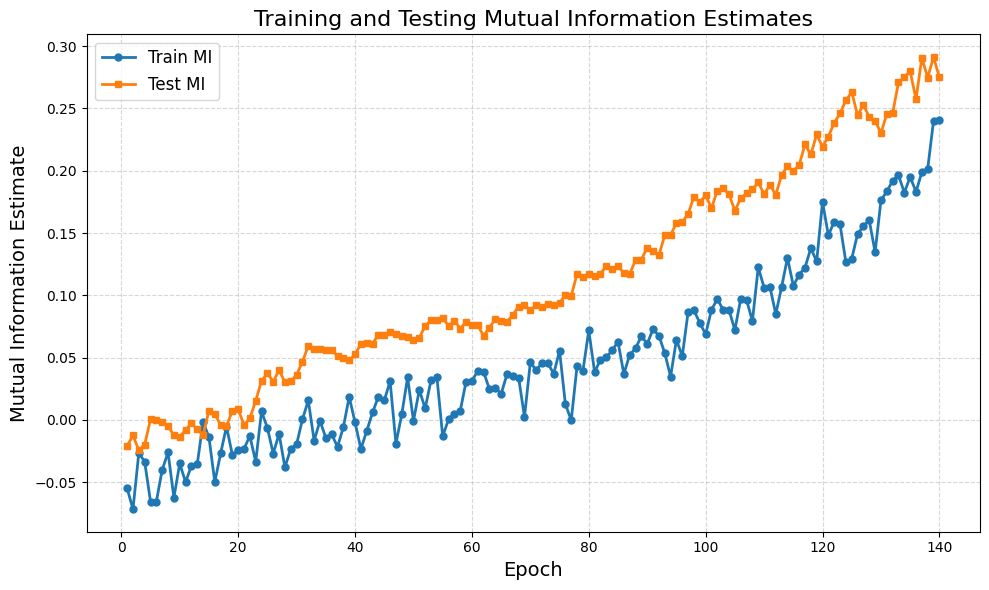

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
epochs = range(1, len(train_mi_history) + 1)

# Plotting Train MI
plt.plot(epochs, train_mi_history, '-o', linewidth=2, markersize=5, label='Train MI')

# Plotting Test MI
plt.plot(epochs, test_mi_history, '-s', linewidth=2, markersize=5, label='Test MI')

# Labels and Title
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Mutual Information Estimate', fontsize=14)
plt.title('Training and Testing Mutual Information Estimates', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.5)

# Legend explicitly
plt.legend(fontsize=12)

# Clear layout and presentation
plt.tight_layout()

plt.show()


<ipython-input-94-ffcbdf7a27f4>:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, odor].boxplot(
<ipython-input-94-ffcbdf7a27f4>:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, odor].boxplot(
<ipython-input-94-ffcbdf7a27f4>:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, odor].boxplot(
<ipython-input-94-ffcbdf7a27f4>:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, odor].boxplot(
<ipython-input-94-ffcbdf7a27f4>:38: MatplotlibDeprecationWarning: The 'labels' p

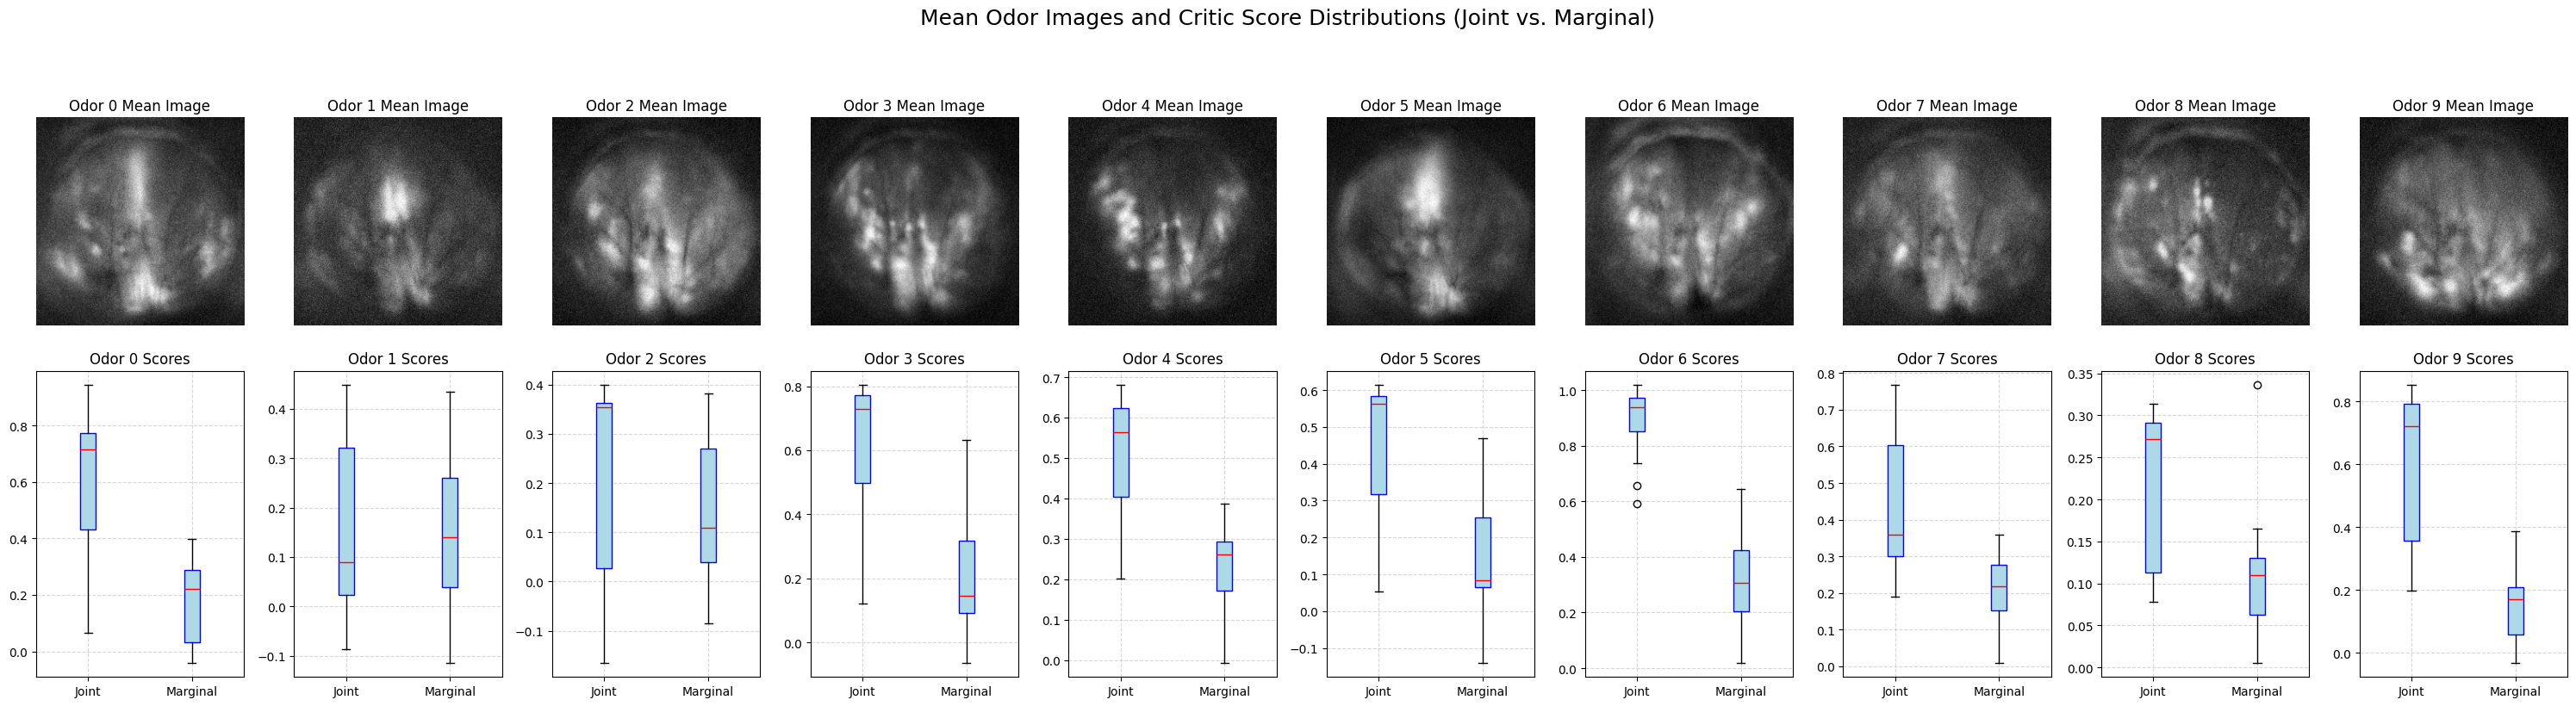

In [ ]:
plot_odor_comparison(test_dataset, test_loader, critic_model, device)

# Wasserstein Distance

In [ ]:
loss_functional = wasserstein_loss

In [ ]:
# Initialize model
critic_model = RobustCriticMLP(num_odors=10)

# Dummy inputs clearly for quick verification
dummy_labels = torch.randint(0, 10, (8,))
joint_embeddings = torch.randn(8, 65536)
marginal_embeddings = torch.randn(8, 65536)

loss, mi_estimate = loss_functional(critic_model, dummy_labels, joint_embeddings, marginal_embeddings)

print(f"Loss: {loss.item():.4f}, MI Estimate: {mi_estimate:.4f}")

Loss: -0.0067, MI Estimate: 0.0067


In [ ]:
num_epochs = 90
learning_rate = 1e-4
lambda_gp = 0.1  # Gradient penalty coefficient explicitly recommended
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

critic_model = RobustCriticMLP(num_odors=11, dropout_p=0.1).to(device)
optimizer = torch.optim.Adam(critic_model.parameters(), lr=learning_rate)

train_mi_history, test_mi_history = [], []

for epoch in range(num_epochs):
    critic_model.train()
    train_loss, train_estimate = 0.0, 0.0

    for odor_labels, joint_imgs, marginal_imgs, _, __ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        odor_labels, joint_imgs, marginal_imgs = odor_labels.to(device), joint_imgs.to(device), marginal_imgs.to(device)

        optimizer.zero_grad()

        # Wasserstein loss explicitly
        loss, estimate = loss_functional(critic_model, odor_labels, joint_imgs, marginal_imgs)

        # Gradient penalty explicitly
        gp = gradient_penalty(critic_model, odor_labels, joint_imgs, marginal_imgs, device)

        total_loss = loss + lambda_gp * gp
        total_loss.backward()
        optimizer.step()

        train_loss += total_loss.item()
        train_estimate += estimate

    avg_train_loss = train_loss / len(train_loader)
    avg_train_estimate = train_estimate / len(train_loader)
    train_mi_history.append(avg_train_estimate)

    # Evaluation loop explicitly remains similar (but no GP needed explicitly)
    critic_model.eval()
    test_loss, test_estimate = 0.0, 0.0
    with torch.no_grad():
        for odor_labels, joint_imgs, marginal_imgs, _, __ in tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Test]"):
            odor_labels, joint_imgs, marginal_imgs = odor_labels.to(device), joint_imgs.to(device), marginal_imgs.to(device)

            loss, estimate = wasserstein_loss(critic_model, odor_labels, joint_imgs, marginal_imgs)

            test_loss += loss.item()
            test_estimate += estimate

    avg_test_loss = test_loss / len(test_loader)
    avg_test_estimate = test_estimate / len(test_loader)
    test_mi_history.append(avg_test_estimate)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Wasserstein: {avg_train_estimate:.4f}, Test Wasserstein: {avg_test_estimate:.4f}")

print("Wasserstein Training complete explicitly.")

Epoch 1/90 [Test]: 100%|██████████| 19/19 [00:00<00:00, 365.30it/s]


Epoch [1/90] - Train Wasserstein: 0.0103, Test Wasserstein: 0.0041


Epoch 2/90 [Test]: 100%|██████████| 19/19 [00:00<00:00, 431.03it/s]


Epoch [2/90] - Train Wasserstein: 0.0150, Test Wasserstein: 0.0330


Epoch 3/90 [Test]: 100%|██████████| 19/19 [00:00<00:00, 412.56it/s]


Epoch [3/90] - Train Wasserstein: 0.0215, Test Wasserstein: 0.0500


Epoch 4/90 [Test]: 100%|██████████| 19/19 [00:00<00:00, 345.32it/s]


Epoch [4/90] - Train Wasserstein: -0.0101, Test Wasserstein: 0.0191


Epoch 5/90 [Test]: 100%|██████████| 19/19 [00:00<00:00, 200.86it/s]


Epoch [5/90] - Train Wasserstein: 0.0082, Test Wasserstein: -0.0116


Epoch 6/90 [Test]: 100%|██████████| 19/19 [00:00<00:00, 230.33it/s]


Epoch [6/90] - Train Wasserstein: 0.0413, Test Wasserstein: 0.0205


Epoch 7/90 [Test]: 100%|██████████| 19/19 [00:00<00:00, 510.38it/s]


Epoch [7/90] - Train Wasserstein: 0.0048, Test Wasserstein: 0.0271


Epoch 8/90 [Test]: 100%|██████████| 19/19 [00:00<00:00, 540.26it/s]


Epoch [8/90] - Train Wasserstein: -0.0011, Test Wasserstein: 0.0231


Epoch 9/90 [Test]: 100%|██████████| 19/19 [00:00<00:00, 539.75it/s]


Epoch [9/90] - Train Wasserstein: 0.0087, Test Wasserstein: 0.0629


Epoch 10/90 [Test]: 100%|██████████| 19/19 [00:00<00:00, 496.77it/s]


Epoch [10/90] - Train Wasserstein: 0.0066, Test Wasserstein: 0.0628


Epoch 11/90 [Test]: 100%|██████████| 19/19 [00:00<00:00, 561.42it/s]


Epoch [11/90] - Train Wasserstein: 0.0195, Test Wasserstein: 0.0490


Epoch 12/90 [Test]: 100%|██████████| 19/19 [00:00<00:00, 535.47it/s]


Epoch [12/90] - Train Wasserstein: 0.0281, Test Wasserstein: 0.0329


Epoch 13/90 [Test]: 100%|██████████| 19/19 [00:00<00:00, 533.25it/s]


Epoch [13/90] - Train Wasserstein: 0.0180, Test Wasserstein: 0.0704


Epoch 14/90 [Test]: 100%|██████████| 19/19 [00:00<00:00, 528.40it/s]


Epoch [14/90] - Train Wasserstein: 0.0420, Test Wasserstein: 0.0534


Epoch 15/90 [Test]: 100%|██████████| 19/19 [00:00<00:00, 521.20it/s]


Epoch [15/90] - Train Wasserstein: 0.0155, Test Wasserstein: 0.0475


Epoch 16/90 [Test]: 100%|██████████| 19/19 [00:00<00:00, 533.19it/s]


Epoch [16/90] - Train Wasserstein: 0.0278, Test Wasserstein: 0.0539


Epoch 17/90 [Test]: 100%|██████████| 19/19 [00:00<00:00, 535.10it/s]


Epoch [17/90] - Train Wasserstein: 0.0158, Test Wasserstein: 0.0638


Epoch 18/90 [Test]: 100%|██████████| 19/19 [00:00<00:00, 503.85it/s]


Epoch [18/90] - Train Wasserstein: 0.0273, Test Wasserstein: 0.0515


Epoch 19/90 [Test]: 100%|██████████| 19/19 [00:00<00:00, 512.82it/s]


Epoch [19/90] - Train Wasserstein: 0.0118, Test Wasserstein: 0.0406


Epoch 20/90 [Test]: 100%|██████████| 19/19 [00:00<00:00, 424.26it/s]


Epoch [20/90] - Train Wasserstein: 0.0454, Test Wasserstein: 0.0366


Epoch 21/90 [Test]: 100%|██████████| 19/19 [00:00<00:00, 167.26it/s]


Epoch [21/90] - Train Wasserstein: 0.0405, Test Wasserstein: 0.0304


Epoch 22/90 [Test]: 100%|██████████| 19/19 [00:00<00:00, 224.28it/s]


Epoch [22/90] - Train Wasserstein: 0.0286, Test Wasserstein: 0.0814


Epoch 23/90 [Test]: 100%|██████████| 19/19 [00:00<00:00, 106.78it/s]


Epoch [23/90] - Train Wasserstein: 0.0449, Test Wasserstein: 0.1026


Epoch 24/90 [Test]: 100%|██████████| 19/19 [00:00<00:00, 258.97it/s]


Epoch [24/90] - Train Wasserstein: 0.0642, Test Wasserstein: 0.1020


Epoch 25/90 [Test]: 100%|██████████| 19/19 [00:00<00:00, 515.21it/s]


Epoch [25/90] - Train Wasserstein: 0.0621, Test Wasserstein: 0.0929


Epoch 26/90 [Test]: 100%|██████████| 19/19 [00:00<00:00, 503.77it/s]


Epoch [26/90] - Train Wasserstein: 0.0297, Test Wasserstein: 0.1443


Epoch 27/90 [Test]: 100%|██████████| 19/19 [00:00<00:00, 487.87it/s]


Epoch [27/90] - Train Wasserstein: 0.0607, Test Wasserstein: 0.1632


Epoch 28/90 [Test]: 100%|██████████| 19/19 [00:00<00:00, 536.28it/s]


Epoch [28/90] - Train Wasserstein: 0.0355, Test Wasserstein: 0.1608


Epoch 29/90 [Test]: 100%|██████████| 19/19 [00:00<00:00, 549.97it/s]


Epoch [29/90] - Train Wasserstein: 0.0280, Test Wasserstein: 0.1828


Epoch 30/90 [Test]: 100%|██████████| 19/19 [00:00<00:00, 526.48it/s]


Epoch [30/90] - Train Wasserstein: 0.0658, Test Wasserstein: 0.1508


Epoch 31/90 [Test]: 100%|██████████| 19/19 [00:00<00:00, 515.63it/s]


Epoch [31/90] - Train Wasserstein: 0.0321, Test Wasserstein: 0.1442


Epoch 32/90 [Test]: 100%|██████████| 19/19 [00:00<00:00, 535.64it/s]


Epoch [32/90] - Train Wasserstein: 0.0621, Test Wasserstein: 0.1420


Epoch 33/90 [Test]: 100%|██████████| 19/19 [00:00<00:00, 514.14it/s]


Epoch [33/90] - Train Wasserstein: 0.0570, Test Wasserstein: 0.1421


Epoch 34/90 [Test]: 100%|██████████| 19/19 [00:00<00:00, 528.58it/s]


Epoch [34/90] - Train Wasserstein: 0.0510, Test Wasserstein: 0.1648


Epoch 35/90 [Test]: 100%|██████████| 19/19 [00:00<00:00, 405.24it/s]


Epoch [35/90] - Train Wasserstein: 0.0599, Test Wasserstein: 0.1807


Epoch 36/90 [Test]: 100%|██████████| 19/19 [00:00<00:00, 513.28it/s]


Epoch [36/90] - Train Wasserstein: 0.0827, Test Wasserstein: 0.1956


Epoch 37/90 [Test]: 100%|██████████| 19/19 [00:00<00:00, 383.28it/s]


Epoch [37/90] - Train Wasserstein: 0.0720, Test Wasserstein: 0.1730


Epoch 38/90 [Test]: 100%|██████████| 19/19 [00:00<00:00, 385.80it/s]


Epoch [38/90] - Train Wasserstein: 0.0690, Test Wasserstein: 0.1734


Epoch 39/90 [Test]: 100%|██████████| 19/19 [00:00<00:00, 415.87it/s]


Epoch [39/90] - Train Wasserstein: 0.0904, Test Wasserstein: 0.1713


Epoch 40/90 [Test]: 100%|██████████| 19/19 [00:00<00:00, 285.87it/s]


Epoch [40/90] - Train Wasserstein: 0.0865, Test Wasserstein: 0.2075


Epoch 41/90 [Test]: 100%|██████████| 19/19 [00:00<00:00, 526.98it/s]


Epoch [41/90] - Train Wasserstein: 0.0954, Test Wasserstein: 0.1865


Epoch 42/90 [Test]: 100%|██████████| 19/19 [00:00<00:00, 513.55it/s]


Epoch [42/90] - Train Wasserstein: 0.0955, Test Wasserstein: 0.2503


Epoch 43/90 [Test]: 100%|██████████| 19/19 [00:00<00:00, 530.91it/s]


Epoch [43/90] - Train Wasserstein: 0.0891, Test Wasserstein: 0.2391


Epoch 44/90 [Test]: 100%|██████████| 19/19 [00:00<00:00, 533.36it/s]


Epoch [44/90] - Train Wasserstein: 0.1033, Test Wasserstein: 0.2269


Epoch 45/90 [Test]: 100%|██████████| 19/19 [00:00<00:00, 540.70it/s]


Epoch [45/90] - Train Wasserstein: 0.1245, Test Wasserstein: 0.2564


Epoch 46/90 [Test]: 100%|██████████| 19/19 [00:00<00:00, 537.99it/s]


Epoch [46/90] - Train Wasserstein: 0.1148, Test Wasserstein: 0.2470


Epoch 47/90 [Test]: 100%|██████████| 19/19 [00:00<00:00, 525.06it/s]


Epoch [47/90] - Train Wasserstein: 0.1180, Test Wasserstein: 0.2665


Epoch 48/90 [Test]: 100%|██████████| 19/19 [00:00<00:00, 521.53it/s]


Epoch [48/90] - Train Wasserstein: 0.1270, Test Wasserstein: 0.2321


Epoch 49/90 [Test]: 100%|██████████| 19/19 [00:00<00:00, 506.62it/s]


Epoch [49/90] - Train Wasserstein: 0.1327, Test Wasserstein: 0.2576


Epoch 50/90 [Test]: 100%|██████████| 19/19 [00:00<00:00, 537.77it/s]


Epoch [50/90] - Train Wasserstein: 0.1276, Test Wasserstein: 0.2687


Epoch 51/90 [Test]: 100%|██████████| 19/19 [00:00<00:00, 432.19it/s]


Epoch [51/90] - Train Wasserstein: 0.1307, Test Wasserstein: 0.2479


Epoch 52/90 [Test]: 100%|██████████| 19/19 [00:00<00:00, 536.35it/s]


Epoch [52/90] - Train Wasserstein: 0.1249, Test Wasserstein: 0.2856


Epoch 53/90 [Test]: 100%|██████████| 19/19 [00:00<00:00, 510.82it/s]


Epoch [53/90] - Train Wasserstein: 0.1685, Test Wasserstein: 0.2856


Epoch 54/90 [Test]: 100%|██████████| 19/19 [00:00<00:00, 524.03it/s]


Epoch [54/90] - Train Wasserstein: 0.1435, Test Wasserstein: 0.2674


Epoch 55/90 [Test]: 100%|██████████| 19/19 [00:00<00:00, 521.96it/s]


Epoch [55/90] - Train Wasserstein: 0.1762, Test Wasserstein: 0.3262


Epoch 56/90 [Test]: 100%|██████████| 19/19 [00:00<00:00, 529.09it/s]


Epoch [56/90] - Train Wasserstein: 0.1761, Test Wasserstein: 0.3666


Epoch 57/90 [Test]: 100%|██████████| 19/19 [00:00<00:00, 378.01it/s]


Epoch [57/90] - Train Wasserstein: 0.1890, Test Wasserstein: 0.3540


Epoch 58/90 [Test]: 100%|██████████| 19/19 [00:00<00:00, 174.76it/s]


Epoch [58/90] - Train Wasserstein: 0.1600, Test Wasserstein: 0.3305


Epoch 59/90 [Test]: 100%|██████████| 19/19 [00:00<00:00, 313.36it/s]


Epoch [59/90] - Train Wasserstein: 0.2050, Test Wasserstein: 0.3633


Epoch 60/90 [Test]: 100%|██████████| 19/19 [00:00<00:00, 505.62it/s]


Epoch [60/90] - Train Wasserstein: 0.1699, Test Wasserstein: 0.3540


Epoch 61/90 [Test]: 100%|██████████| 19/19 [00:00<00:00, 518.36it/s]


Epoch [61/90] - Train Wasserstein: 0.1982, Test Wasserstein: 0.3561


Epoch 62/90 [Test]: 100%|██████████| 19/19 [00:00<00:00, 511.79it/s]


Epoch [62/90] - Train Wasserstein: 0.2348, Test Wasserstein: 0.3467


Epoch 63/90 [Test]: 100%|██████████| 19/19 [00:00<00:00, 514.58it/s]


Epoch [63/90] - Train Wasserstein: 0.2452, Test Wasserstein: 0.3813


Epoch 64/90 [Test]: 100%|██████████| 19/19 [00:00<00:00, 351.40it/s]


Epoch [64/90] - Train Wasserstein: 0.1814, Test Wasserstein: 0.4154


Epoch 65/90 [Test]: 100%|██████████| 19/19 [00:00<00:00, 522.57it/s]


Epoch [65/90] - Train Wasserstein: 0.2692, Test Wasserstein: 0.4194


Epoch 66/90 [Test]: 100%|██████████| 19/19 [00:00<00:00, 370.75it/s]


Epoch [66/90] - Train Wasserstein: 0.2590, Test Wasserstein: 0.3813


Epoch 67/90 [Test]: 100%|██████████| 19/19 [00:00<00:00, 535.61it/s]


Epoch [67/90] - Train Wasserstein: 0.2340, Test Wasserstein: 0.3982


Epoch 68/90 [Test]: 100%|██████████| 19/19 [00:00<00:00, 533.56it/s]


Epoch [68/90] - Train Wasserstein: 0.2435, Test Wasserstein: 0.3822


Epoch 69/90 [Test]: 100%|██████████| 19/19 [00:00<00:00, 534.00it/s]


Epoch [69/90] - Train Wasserstein: 0.2839, Test Wasserstein: 0.4279


Epoch 70/90 [Test]: 100%|██████████| 19/19 [00:00<00:00, 430.59it/s]


Epoch [70/90] - Train Wasserstein: 0.3056, Test Wasserstein: 0.4774


Epoch 71/90 [Test]: 100%|██████████| 19/19 [00:00<00:00, 522.51it/s]


Epoch [71/90] - Train Wasserstein: 0.2984, Test Wasserstein: 0.3631


Epoch 72/90 [Test]: 100%|██████████| 19/19 [00:00<00:00, 520.21it/s]


Epoch [72/90] - Train Wasserstein: 0.3164, Test Wasserstein: 0.4590


Epoch 73/90 [Test]: 100%|██████████| 19/19 [00:00<00:00, 534.93it/s]


Epoch [73/90] - Train Wasserstein: 0.3057, Test Wasserstein: 0.3583


Epoch 74/90 [Test]: 100%|██████████| 19/19 [00:00<00:00, 532.91it/s]


Epoch [74/90] - Train Wasserstein: 0.3231, Test Wasserstein: 0.4465


Epoch 75/90 [Test]: 100%|██████████| 19/19 [00:00<00:00, 330.54it/s]


Epoch [75/90] - Train Wasserstein: 0.3608, Test Wasserstein: 0.4632


Epoch 76/90 [Test]: 100%|██████████| 19/19 [00:00<00:00, 254.08it/s]


Epoch [76/90] - Train Wasserstein: 0.3007, Test Wasserstein: 0.4618


Epoch 77/90 [Test]: 100%|██████████| 19/19 [00:00<00:00, 397.52it/s]


Epoch [77/90] - Train Wasserstein: 0.3302, Test Wasserstein: 0.4697


Epoch 78/90 [Test]: 100%|██████████| 19/19 [00:00<00:00, 191.76it/s]


Epoch [78/90] - Train Wasserstein: 0.3470, Test Wasserstein: 0.4547


Epoch 79/90 [Test]: 100%|██████████| 19/19 [00:00<00:00, 506.65it/s]


Epoch [79/90] - Train Wasserstein: 0.3569, Test Wasserstein: 0.4983


Epoch 80/90 [Test]: 100%|██████████| 19/19 [00:00<00:00, 534.65it/s]


Epoch [80/90] - Train Wasserstein: 0.3573, Test Wasserstein: 0.4825


Epoch 81/90 [Test]: 100%|██████████| 19/19 [00:00<00:00, 527.43it/s]


Epoch [81/90] - Train Wasserstein: 0.3937, Test Wasserstein: 0.4639


Epoch 82/90 [Test]: 100%|██████████| 19/19 [00:00<00:00, 523.34it/s]


Epoch [82/90] - Train Wasserstein: 0.4071, Test Wasserstein: 0.5388


Epoch 83/90 [Test]: 100%|██████████| 19/19 [00:00<00:00, 520.57it/s]


Epoch [83/90] - Train Wasserstein: 0.4575, Test Wasserstein: 0.5123


Epoch 84/90 [Test]: 100%|██████████| 19/19 [00:00<00:00, 508.15it/s]


Epoch [84/90] - Train Wasserstein: 0.4434, Test Wasserstein: 0.6024


Epoch 85/90 [Test]: 100%|██████████| 19/19 [00:00<00:00, 506.45it/s]


Epoch [85/90] - Train Wasserstein: 0.4343, Test Wasserstein: 0.5203


Epoch 86/90 [Test]: 100%|██████████| 19/19 [00:00<00:00, 519.07it/s]


Epoch [86/90] - Train Wasserstein: 0.4223, Test Wasserstein: 0.6299


Epoch 87/90 [Test]: 100%|██████████| 19/19 [00:00<00:00, 539.27it/s]


Epoch [87/90] - Train Wasserstein: 0.4610, Test Wasserstein: 0.5340


Epoch 88/90 [Test]: 100%|██████████| 19/19 [00:00<00:00, 529.40it/s]


Epoch [88/90] - Train Wasserstein: 0.4364, Test Wasserstein: 0.6163


Epoch 89/90 [Test]: 100%|██████████| 19/19 [00:00<00:00, 520.59it/s]


Epoch [89/90] - Train Wasserstein: 0.5386, Test Wasserstein: 0.5920


Epoch 90/90 [Test]: 100%|██████████| 19/19 [00:00<00:00, 503.92it/s]

Epoch [90/90] - Train Wasserstein: 0.4898, Test Wasserstein: 0.6936
Wasserstein Training complete explicitly.


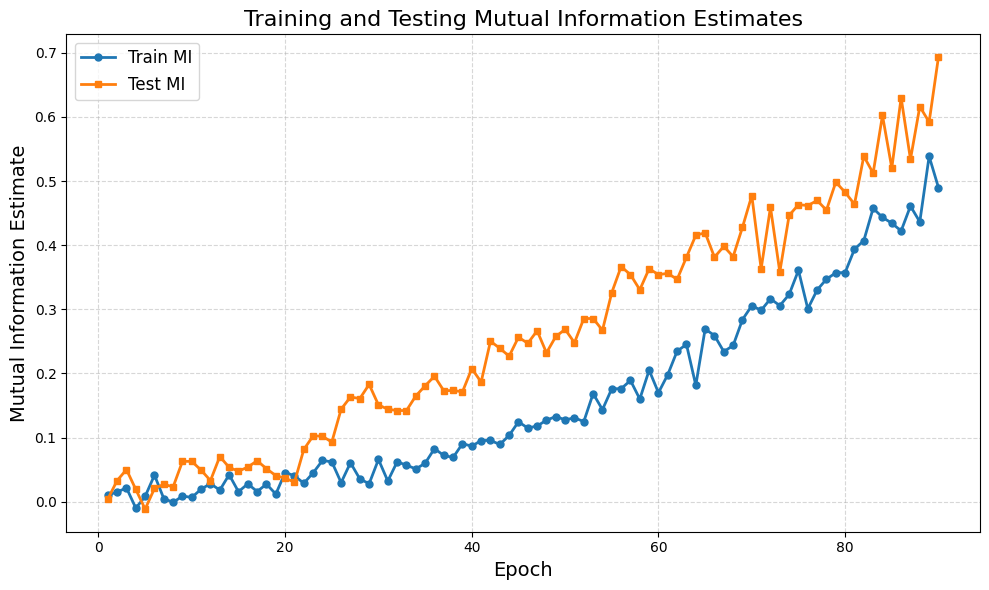

In [ ]:
plt.figure(figsize=(10,6))
epochs = range(1, len(train_mi_history) + 1)

# Plotting Train MI
plt.plot(epochs, train_mi_history, '-o', linewidth=2, markersize=5, label='Train MI')

# Plotting Test MI
plt.plot(epochs, test_mi_history, '-s', linewidth=2, markersize=5, label='Test MI')

# Labels and Title
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Mutual Information Estimate', fontsize=14)
plt.title('Training and Testing Mutual Information Estimates', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.5)

# Legend
plt.legend(fontsize=12)


plt.tight_layout()

plt.show()

<ipython-input-94-ffcbdf7a27f4>:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, odor].boxplot(
<ipython-input-94-ffcbdf7a27f4>:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, odor].boxplot(
<ipython-input-94-ffcbdf7a27f4>:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, odor].boxplot(
<ipython-input-94-ffcbdf7a27f4>:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, odor].boxplot(
<ipython-input-94-ffcbdf7a27f4>:38: MatplotlibDeprecationWarning: The 'labels' p

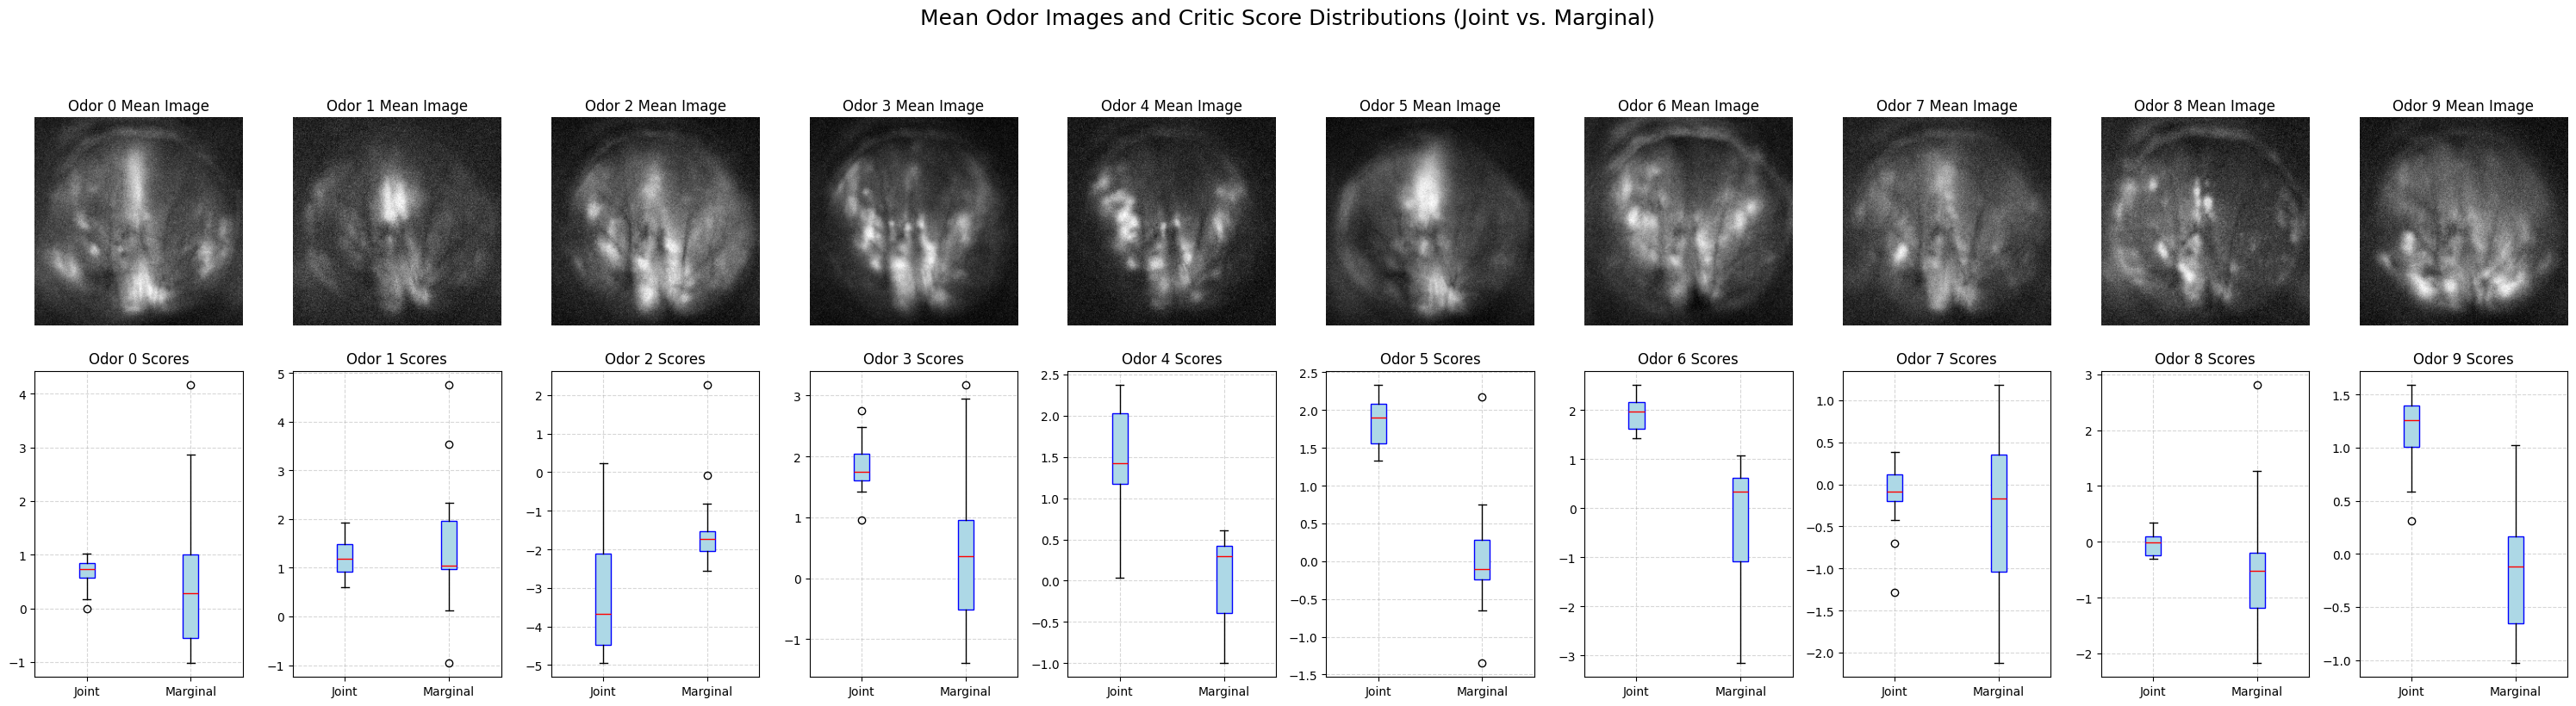

In [ ]:
plot_odor_comparison(test_dataset, test_loader, critic_model, device)